In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("incl/")

import ELPH_dyn
import ELPH_utils


#global hyperparameters
kmax = 4.
n_kmax = 80


# init = ELPH_dyn.get_init_cond_gauss(kmax = kmax, n_kmax = n_kmax, max_pos = 0.15, width = 0.05, density=density)
# plt.plot(init[:n_kmax])
# plt.show()

# nkdyn = ELPH_dyn.get_el_dynamics(init, n_kmax = n_kmax)
# plt.imshow(nkdyn, aspect='auto')
# plt.colorbar()
# plt.show()

In [2]:
n_runs = 100

paras = np.zeros((n_runs,3))

paras[:,0] = np.linspace(0.1,0.7,n_runs) #max_pos
paras[:,1] = 0.05 #width
paras[:,2] = 0.1 #density

runs = ELPH_utils.get_runs_gaussian_init(kmax, n_kmax, paras, tmax=2000, n_tmax=400)


run  1  from  100
run  2  from  100
run  3  from  100
run  4  from  100
run  5  from  100
run  6  from  100
run  7  from  100
run  8  from  100
run  9  from  100
run  10  from  100
run  11  from  100
run  12  from  100
run  13  from  100
run  14  from  100
run  15  from  100
run  16  from  100
run  17  from  100
run  18  from  100
run  19  from  100
run  20  from  100
run  21  from  100
run  22  from  100
run  23  from  100
run  24  from  100
run  25  from  100
run  26  from  100
run  27  from  100
run  28  from  100
run  29  from  100
run  30  from  100
run  31  from  100
run  32  from  100
run  33  from  100
run  34  from  100
run  35  from  100
run  36  from  100
run  37  from  100
run  38  from  100
run  39  from  100
run  40  from  100
run  41  from  100
run  42  from  100
run  43  from  100
run  44  from  100
run  45  from  100
run  46  from  100
run  47  from  100
run  48  from  100
run  49  from  100
run  50  from  100
run  51  from  100
run  52  from  100
run  53  from  100
ru

In [3]:
np.savez("../runs", runs)

['arr_0']
<class 'numpy.ndarray'>
(100, 80, 400)
<class 'list'>
<class 'numpy.ndarray'>
(80, 400)


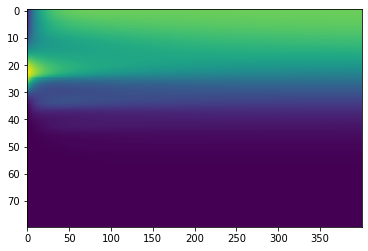

In [4]:
npz_runs = np.load("../runs.npz")
print(npz_runs.files)
print(type(npz_runs['arr_0']))
print(npz_runs['arr_0'].shape)
test = np.split(npz_runs['arr_0'], npz_runs['arr_0'].shape[0], axis=0)

for k in range(len(test)):
    test[k] = np.reshape(test[k], test[k].shape[1:])
print(type(test))
print(type(test[1]))
print(test[1].shape)

plt.imshow(test[1], aspect='auto')
plt.show()

runs[0] shape:  (80, 400)


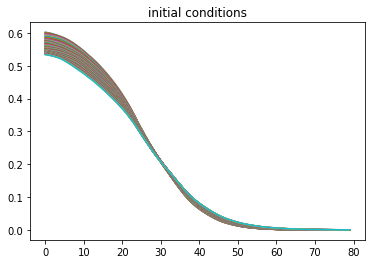

In [5]:
# plt.imshow(runs[1], aspect='auto')
# plt.colorbar()
# plt.show()

print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('initial conditions')
plt.show()

In [6]:
from ELPH_VAR import SVDVAR
    
VAR = SVDVAR(runs, rdim=10, n_VAR_steps=5)

VAR.train(alpha=10**-2.7, rdim = 20, n_VAR_steps = 20, method='ridge')

VAR.print_status()


rdim:  20
n_VAR_steps:  20
state shape:  (400, 38000)
target shape:  (20, 38000)
weights shape:  (400, 20)


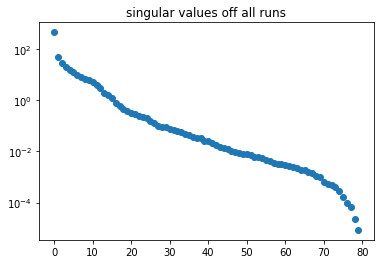

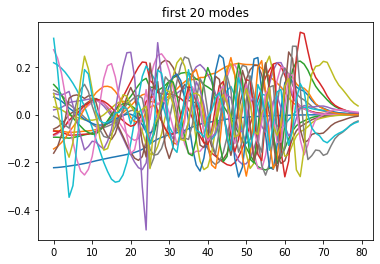

In [7]:
plt.semilogy(VAR.S, 'o')
plt.title('singular values off all runs')
plt.show()
 
for l in range(VAR.rdim):
  plt.plot(VAR.U[:,l],  label='Uhat_'+str(l))
plt.title('first ' + str(VAR.rdim) + ' modes')
plt.show()

0.0719490190851839


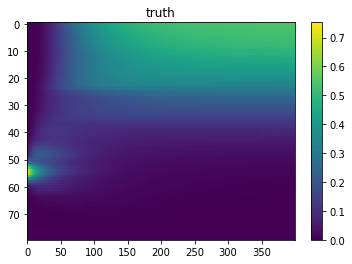

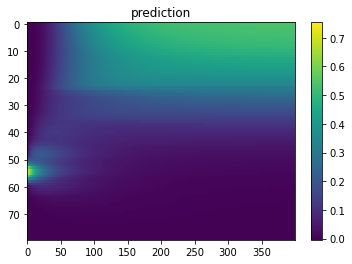

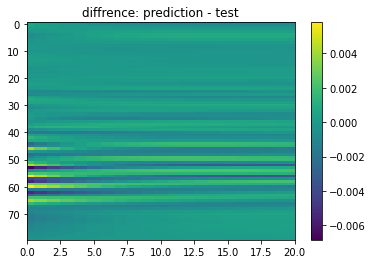

In [8]:

run = runs[80]
testpred = VAR.predict_single_run(run)

print(VAR.get_error(run, norm='fro') )

plt.imshow(run, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('truth')
plt.show()

plt.imshow(testpred, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('prediction')
plt.show()

plt.imshow(run-testpred, aspect='auto', interpolation='None')
plt.colorbar()
plt.title('diffrence: prediction - test')
plt.xlim(0,20)
plt.show()

In [9]:
train_kwargs = {'alpha':10**-2.7, 'rdim':20, 'n_VAR_steps':20}
score_kwargs = {'norm':'max', 'errSVD':False}

mean_score, scores = ELPH_utils.get_KFold_CV_scores(VAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)

print('mean score: ', mean_score)
print('scores: ', scores)


mean score:  0.00839280148274174
scores:  [0.007574547487235661, 0.008826140534488597, 0.008254176717754805, 0.009090523482987157, 0.008218619191242487]


In [10]:
def get_BO_score(aExp, rdim, n_VAR_steps):
    alpha = 10.0**aExp
    rdim = int(rdim)
    n_VAR_steps = int(n_VAR_steps)
    
    train_kwargs = {'alpha':alpha, 'rdim':rdim, 'n_VAR_steps':n_VAR_steps}
    score_kwargs = {'norm':'fro', 'errSVD':False}
    
    m,s = ELPH_utils.get_KFold_CV_scores(VAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    return -1.*m - 1.*np.std(s)


# print(KFCV_score(-6,3,5))

from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'aExp': [-6, -1], 'rdim': [1,20], 'n_VAR_steps': [1,20]}

optimizer = BayesianOptimization(
    f=get_BO_score,
    pbounds=pbounds,
    random_state=816,
)

# optimizer.maximize(init_points=10, n_iter=100)

rdim:  5
n_VAR_steps:  3
NVAR_p:  2
VAR state shape:  (15, 39303)
NVAR state shape:  (135, 39303)
target shape:  (5, 39303)
weights shape:  (135, 5)


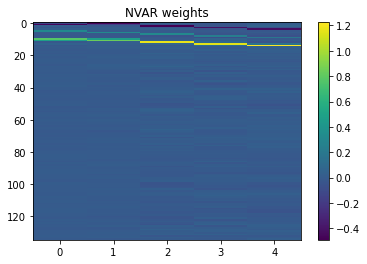

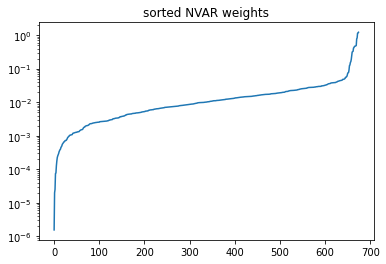

NVAR err:  1.7532577063024075


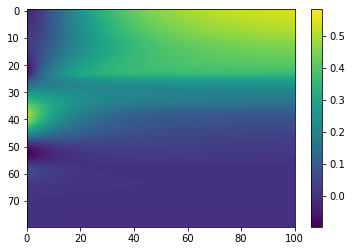

rdim:  5
n_VAR_steps:  3
state shape:  (15, 39303)
target shape:  (5, 39303)
weights shape:  (15, 5)
VAR err:  4.808785268344548


In [11]:

from ELPH_NVAR import SVDNVAR


ntestrun = 32
train_runs = runs.copy()
test_run = train_runs.pop(ntestrun)

a = 1e-2
r = 5
n = 3


NVAR = SVDNVAR(train_runs)

NVAR.train(alpha=a, rdim=r, n_VAR_steps=n, NVAR_p=2)

NVAR.print_status()

plt.imshow(NVAR.w, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()


print('NVAR err: ', NVAR.get_error(test_run, norm='fro') )
trNVAR = NVAR.predict_single_run(test_run)

plt.imshow(trNVAR, aspect='auto')
plt.colorbar()
plt.xlim(0,100)
plt.show()


VAR.load_runs(train_runs)
VAR.train(alpha=a, rdim=r, n_VAR_steps=n)

VAR.print_status()
print('VAR err: ', VAR.get_error(test_run, norm='fro') )
trVAR = VAR.predict_single_run(test_run)






rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 39402)
NVAR state shape:  (861, 39402)
target shape:  (20, 39402)
weights shape:  (861, 20)


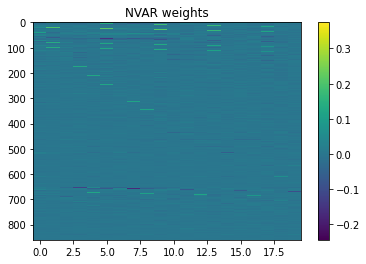

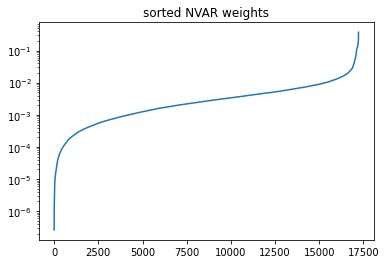

NVAR err:  0.2595100146083278


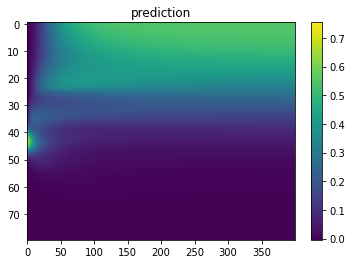

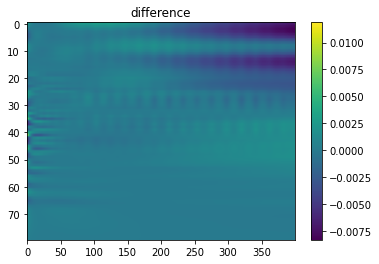

In [12]:
train_runs = runs[::1]
test_run = train_runs.pop(45)

NVAR.load_runs(train_runs)

NVAR.train(rdim=20, n_VAR_steps=2, NVAR_p=2, method='stlsq', alpha=1e-3, threshold=0, intercept=True, standardize=False)

NVAR.print_status()

masked_weights = np.ma.masked_values(NVAR.w,0.0)

plt.imshow(masked_weights, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(NVAR.w))))
plt.title('sorted NVAR weights')
plt.show()


print('NVAR err: ', NVAR.get_error(test_run, norm='fro') )
preNVAR = NVAR.predict_single_run(test_run)

plt.imshow(preNVAR, aspect='auto')
plt.colorbar()
plt.title('prediction')
# plt.xlim(0,100)
plt.show()

plt.imshow(preNVAR-test_run, aspect='auto')
plt.colorbar()
plt.title('difference')
# plt.xlim(0,100)
plt.show()

In [13]:
def get_BayO_score(aExp, thrExp):
    alpha = 10.0**aExp
    threshold = 10**thrExp
    
    train_kwargs = {'alpha':alpha, 'threshold':threshold, 'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'method':'stlsq', 'intercept':True, 'standardize':False}
    score_kwargs = {'norm':'fro', 'errSVD':False}
    
    m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    return -1.*m - 1.*np.std(s)

# print(get_BayO_score(-3,-5))

from bayes_opt import BayesianOptimization
# Bounded region of parameter space
pbounds = {'aExp': [-4, -1], 'thrExp': [-6,-3]}
optimizer = BayesianOptimization(f=get_BayO_score, pbounds=pbounds, random_state=817)

# optimizer.maximize(init_points=10, n_iter=100)

In [14]:
train_kwargs = {'alpha':10**-3.5, 'threshold':10**-3.0, 'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'method':'stlsq', 'intercept':True, 'standardize':False}
score_kwargs = {'norm':'fro', 'errSVD':False}

m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(s)

/usr/local/lib/python3.9/site-packages/numpy/core/numeric.py:936: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/Stefan/Code/ELPH-ML/incl/ELPH_NVAR.py:142: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec
/usr/local/lib/python3.9/site-packages/numpy/core/numeric.py:936: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/Stefan/Code/ELPH-ML/incl/ELPH_NVAR.py:142: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec
/usr/local/lib/python3.9/site-packages/numpy/core/numeric.py:936: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/Users/Stefan/Code/ELPH-ML/incl/ELPH_NVAR.py:142: RuntimeWarning: invalid value encountered in matmul
  pred[:,j] = self.w.T @ NVAR_vec
/usr/local/lib/python3.9/site-packages/n

nan
[nan, nan, nan, nan, nan]


In [15]:
def get_BayO_score(aExp):
    alpha = 10.0**aExp
    
    train_kwargs = {'alpha':alpha, 'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'method':'ridge', 'intercept':True, 'standardize':False}
    score_kwargs = {'norm':'fro', 'errSVD':False}
    
    m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
    return -1.*m - 1.*np.std(s)

# print(get_BayO_score(-3))

from bayes_opt import BayesianOptimization
# Bounded region of parameter space
pbounds = {'aExp': [-4, -1]}
optimizer = BayesianOptimization(f=get_BayO_score, pbounds=pbounds, random_state=817)

# optimizer.maximize(init_points=5, n_iter=60)

rdim:  20
n_VAR_steps:  2
NVAR_p:  2
VAR state shape:  (40, 39402)
NVAR state shape:  (861, 39402)
target shape:  (20, 39402)
weights shape:  (861, 20)
NVAR err:  0.011885955503731171
NVAR err compared to reconstruced run:  0.0023577474410010346


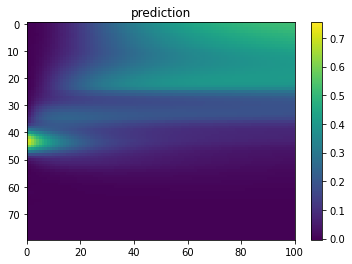

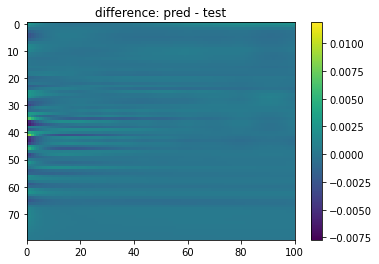

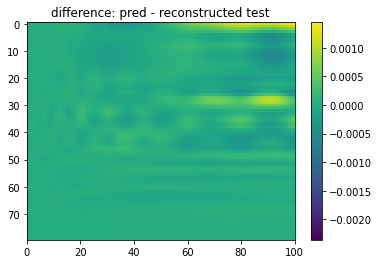

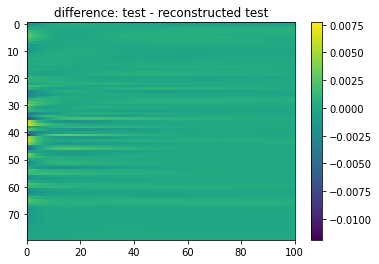

In [21]:
train_runs = runs[::1]
test_run = train_runs.pop(45)

NVAR.load_runs(train_runs)
NVAR.train(rdim=20, n_VAR_steps=2, NVAR_p=2, method='ridge', alpha=10.**-3.4, intercept=True, standardize=False)

NVAR.print_status()


print('NVAR err: ', NVAR.get_error(test_run, norm='max') )
print('NVAR err compared to reconstruced run: ', NVAR.get_error(test_run, norm='max', errSVD=True) )

preNVAR = NVAR.predict_single_run(test_run)
recon_runs = NVAR.Uhat @ NVAR.Uhat.T @ test_run


xmax = 100

plt.imshow(preNVAR, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(preNVAR-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: pred - test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(preNVAR-recon_runs, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: pred - reconstructed test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(test_run-recon_runs, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - reconstructed test')
plt.xlim(0,xmax)
plt.show()

In [17]:
train_kwargs = {'alpha':10**-3.4, 'rdim':20, 'n_VAR_steps':2, 'NVAR_p':2, 'method':'ridge', 'intercept':True, 'standardize':False}
score_kwargs = {'norm':'max', 'errSVD':True}

m,s = ELPH_utils.get_KFold_CV_scores(NVAR, runs, folds=5, seed=817, score_kwargs=score_kwargs, train_kwargs=train_kwargs)
print(m)
print(s)

nan
[nan, nan, nan, nan, nan]


In [20]:
from ELPH_SVDAPPRX import SVDAPPRX

SVDapr = SVDAPPRX(runs)
SVDapr.train()

m,s = ELPH_utils.get_KFold_CV_scores(SVDapr, runs, folds=5, seed=817, train_kwargs={'rdim':20}, score_kwargs={ 'norm':'max'})
print(m)
print(s)


0.008392801482741744
[0.007574547487235614, 0.008826140534488608, 0.008254176717754785, 0.009090523482987231, 0.008218619191242473]


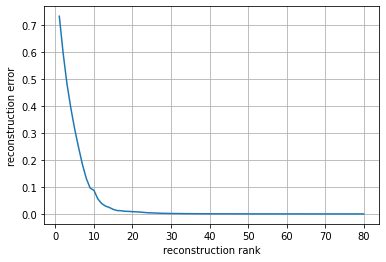

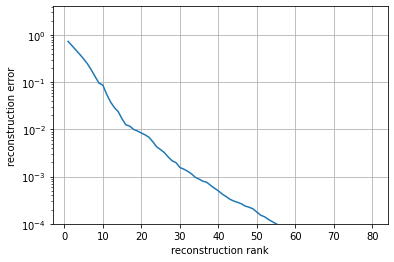

In [19]:
SVD_approx_err = np.zeros(n_kmax)
for rdim in range(n_kmax):
    SVD_approx_err[rdim] = ELPH_utils.get_KFold_CV_scores(SVDapr, runs, folds=5, seed=817, train_kwargs={'rdim':rdim+1}, score_kwargs={ 'norm':'max'})[0]

plt.grid()
plt.plot(np.arange(1,n_kmax+1),SVD_approx_err)
plt.xlabel('reconstruction rank')
plt.ylabel('reconstruction error')
plt.show()

plt.grid()
plt.semilogy(np.arange(1,n_kmax+1),SVD_approx_err)
plt.xlabel('reconstruction rank')
plt.ylabel('reconstruction error')
plt.ylim(1e-4,)
plt.show()